## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

# fin_BUM - Credit fault Classification

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).

**Сроки сдачи**

Cдать проект нужно в течение 7 дней после окончания последнего вебинара.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Анализ данных
3. Обработка пропусков
4. Обработка выбросов
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### План
* [Подготовка](#prep)
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

### Подготовка [<a class='anchor' id='prep'>]()

In [363]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [364]:
# первый взгляд на параметр 
def first_look(Series1, max_count=0, bins=10, quan=0.999):
    Series = Series1.copy()
    Series.dropna(inplace=True)
    # простая корректировка по выбросам
    Series.drop(Series[Series > Series.quantile(quan)].index, inplace=True)
    # расчет осовных значений
    Series_mean = round(Series.mean(), 2)
    Series_median = Series.median()
    Series_name = Series.name
    # рачет максимального выброса
    max_count=np.histogram(Series, bins=bins)[0].max()
    
    plt.figure(figsize = (16, 8))
    Series.hist(bins=bins)
    plt.ylabel('Count')
    plt.xlabel(Series_name)
    # отображение среднего и медианы
    y = np.linspace(0, max_count, bins)
    plt.plot([Series_mean] * bins, y, label='mean  : {:,.2f}'.format(Series_mean),  linewidth=4)
    plt.plot([Series_median] * bins, y, label='median: {:,.2f}'.format(Series_median),  linewidth=4)
    plt.legend()
    plt.title( Series_name + ' distribution')
    plt.show()

In [365]:
# таблица расшифровки кодовых признаков 
def dict_rus(series, list_terms):
    dict_freq = series.value_counts()
    return pd.concat([dict_freq, pd.Series(list_terms, name='рус',index=dict_freq.index)],  axis=1)

In [366]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [367]:
# предсказание с отчетом
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [588]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

**Пути к директориям и файлам**

In [447]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_PATH = './sample_submission.csv'

### Загрузка данных [<a class='anchor' id='load'>]()

In [369]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [370]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [371]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

### EDA [<a class="anchor" id="eda"></a>]()
- Анализ данных
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита 
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Maximum Open Credit** - максимальная сумма, которая когда-либо была доступна клиенту

**Current Loan Amount** - сумма, которую еще предстоит выплатить клиенту

**Current Credit Balance** - сумма, которую может тратить клиент с кредитного счета

### Credit Default - целевая переменная

In [372]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

>Набор данных в разрезе целевой переменной - дисбаланс

In [373]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


>Пропуски

In [374]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [375]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## Количественные переменные

### Annual Income - годовой доход

In [376]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

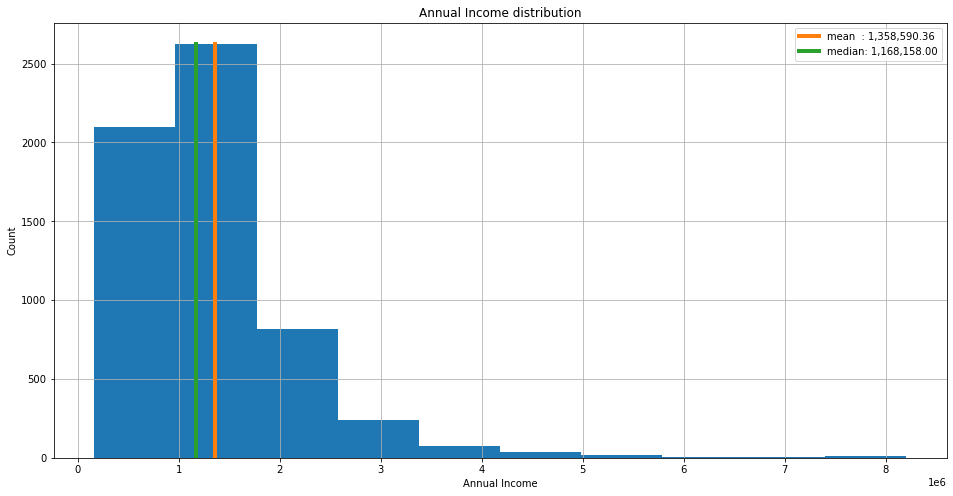

In [377]:
first_look(df_train['Annual Income'])

In [378]:
df_train.loc[~df_train['Annual Income'].isna(), 'Annual Income'].sort_values().tail(50)

585      4772800.0
6997     4824100.0
4439     4831700.0
1078     4846425.0
6727     4867800.0
5415     4906028.0
5365     5038534.0
837      5131482.0
4283     5165264.0
4329     5204632.0
7299     5289676.0
7486     5327372.0
5823     5493527.0
2992     5573460.0
2169     5584271.0
2468     5589420.0
693      5605950.0
4461     5628750.0
602      5631030.0
5934     5703648.0
3399     5712540.0
4445     5725194.0
7089     5759280.0
4271     5798040.0
4745     6029954.0
3269     6133922.0
3927     6222880.0
6946     6492395.0
3550     6495720.0
3446     6611810.0
7036     6620208.0
1615     6651900.0
4685     6961752.0
5108     7236606.0
3081     7381842.0
6604     7476880.0
3683     7514120.0
5102     7637240.0
5774     7655480.0
7097     7660648.0
2606     7883442.0
1616     7907382.0
1601     7999095.0
4491     8200229.0
2474     8633790.0
5396     8710740.0
1984     8758449.0
1025     8923844.0
2200     9338880.0
6472    10149344.0
Name: Annual Income, dtype: float64

<AxesSubplot:xlabel='Annual Income'>

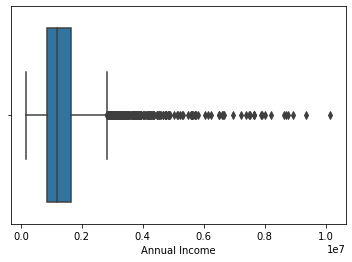

In [379]:
sns.boxplot(x=df_train.loc[~df_train['Annual Income'].isna(), 'Annual Income'])

In [380]:

df_train['Annual Income'].sort_values().tail()


7482   NaN
7492   NaN
7494   NaN
7498   NaN
7499   NaN
Name: Annual Income, dtype: float64

>Выбросы править не будем, заполним пропуски медианой

In [381]:
med=df_train['Annual Income'].median()
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = med

In [382]:
df_train['Annual Income'].isna().sum()

0

### Tax Liens - налоговые обременения

In [383]:
df_train['Tax Liens'].describe()

count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

In [384]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

>Больше - хуже, корретировка не требуется

### Number of Open Accounts - количество открытых счетов

In [385]:
df_train['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

In [386]:
df_train['Number of Open Accounts'].value_counts(sort=False)

11.0    692
15.0    313
8.0     638
13.0    465
12.0    562
9.0     728
10.0    677
7.0     613
6.0     504
14.0    420
3.0      95
20.0     93
22.0     49
18.0    143
5.0     325
16.0    265
4.0     212
2.0      28
24.0     50
32.0      6
30.0     11
28.0     14
26.0     12
33.0      6
35.0      1
17.0    232
41.0      1
19.0    139
23.0     59
21.0     78
25.0     32
31.0      6
29.0     10
27.0     14
34.0      2
38.0      1
42.0      1
43.0      1
37.0      2
Name: Number of Open Accounts, dtype: int64

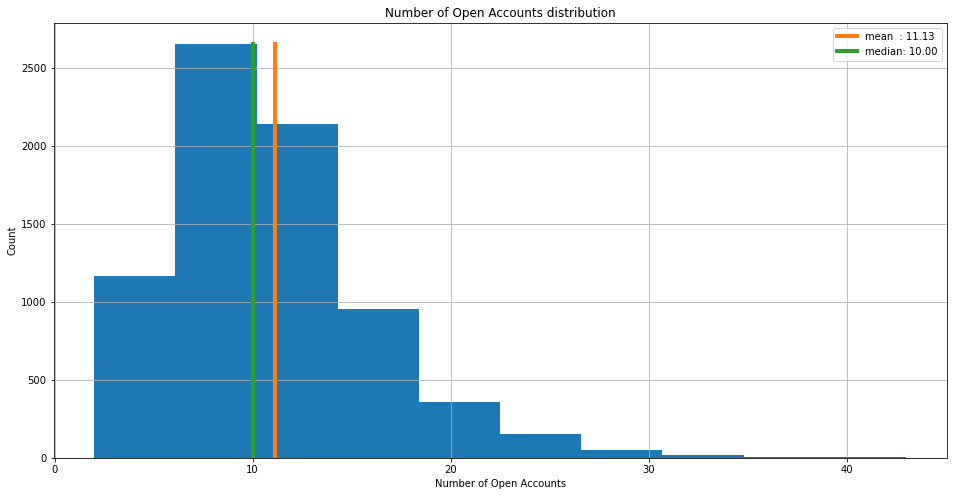

In [387]:
first_look(df_train['Number of Open Accounts'], quan=1)

>Значения адекватные, пропусков нет

### Years of Credit History - количество лет кредитной истории

In [388]:
df_train['Years of Credit History'].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

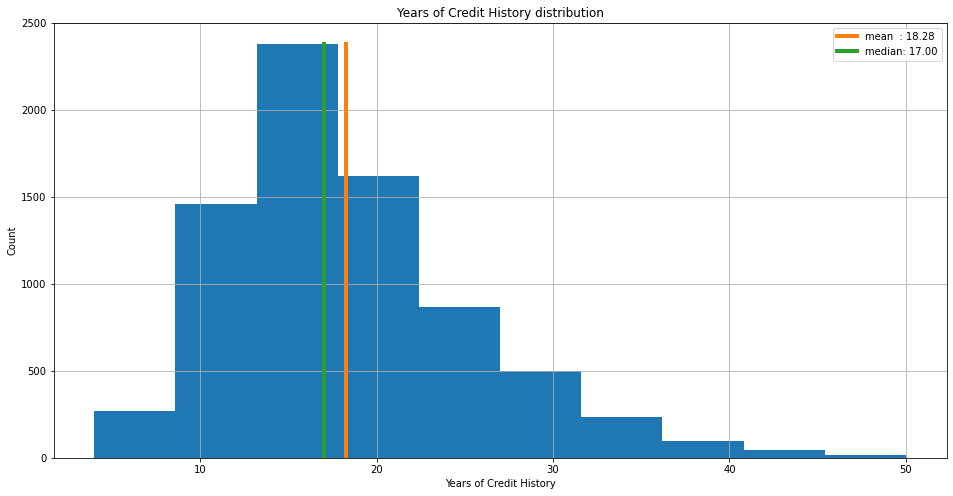

In [389]:
first_look(df_train['Years of Credit History'])

In [390]:
df_train['Years of Credit History'].sort_values().tail()

3628    51.3
4716    51.5
4301    51.9
247     52.2
476     57.7
Name: Years of Credit History, dtype: float64

>Значения адекватные, пропусков нет


### Maximum Open Credit - наибольший открытый кредит

In [391]:
df_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

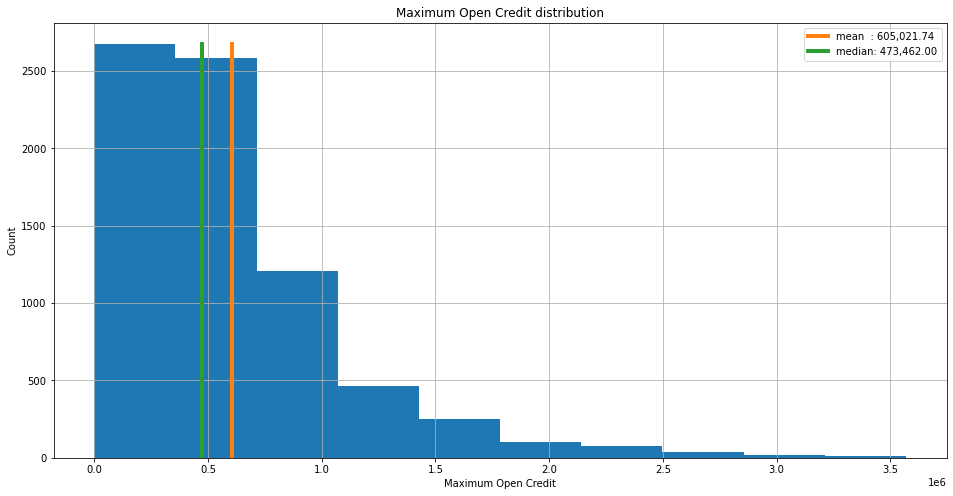

In [392]:
first_look(df_train['Maximum Open Credit'], quan=0.99)

In [393]:
pd.options.display.float_format = '{:,.2f} руб.'.format
print(df_train['Maximum Open Credit'].sort_values().tail(4))
pd.reset_option('display.float_format')

2023      57,562,560.00 руб.
2617     265,512,874.00 руб.
44       380,052,288.00 руб.
617    1,304,726,170.00 руб.
Name: Maximum Open Credit, dtype: float64


>Три последних значения отличаются на порядок от предыдущих, но являются адекватными

> Гипотеза: подмешаны юрлица. выбросы - удалить 

In [394]:
df_train.loc[[2617, 44, 617]]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
617,Home Mortgage,1168386.0,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0


### Number of Credit Problems - количество проблем с кредитом

In [395]:
df_train['Number of Credit Problems'].describe()

count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

In [396]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

>Пропусков нет, признак адеватный

### Months since last delinquent - количество месяцев с последней просрочки платежа

In [397]:
df_train['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

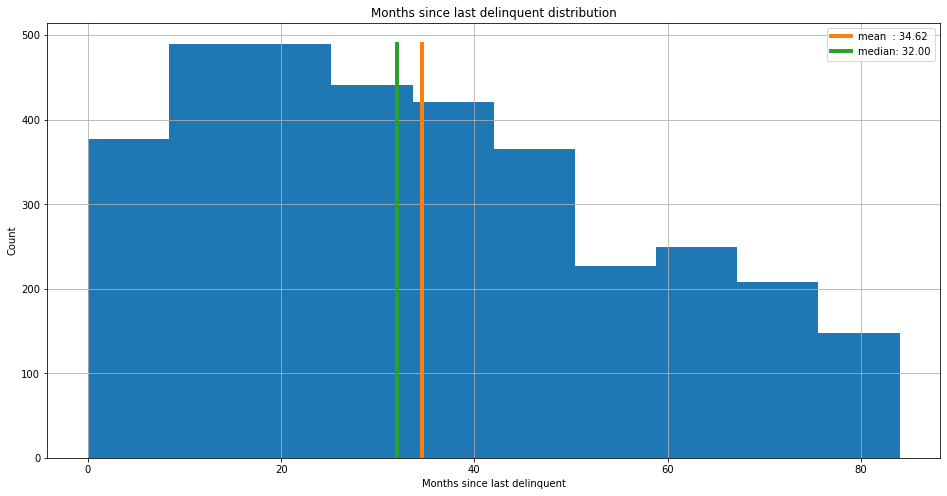

In [398]:
first_look(df_train['Months since last delinquent'])

>Признак важный, но половина пропусков

In [399]:
df_train[df_train['Months since last delinquent']==0]['Months since last delinquent'].count()

18

Гипотеза. Подозрительно мало значений = 0, преобразуем nan в ноль

In [400]:
df_train.loc[df_train['Months since last delinquent'].isna()]=0

### Bankruptcies - банкротства

In [401]:
df_train['Bankruptcies'].describe()

count    7486.000000
mean        0.052498
std         0.242556
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [402]:
df_train['Bankruptcies'].value_counts()

0.0    7120
1.0     345
2.0      16
3.0       4
4.0       1
Name: Bankruptcies, dtype: int64

>Признак важный, всего 14 пропусков. Надо восстановить

> nan значит 0

### Current Loan Amount - текущая сумма кредита

In [403]:
df_train['Current Loan Amount'].describe()

count    7.500000e+03
mean     5.071686e+06
std      2.165776e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.684660e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

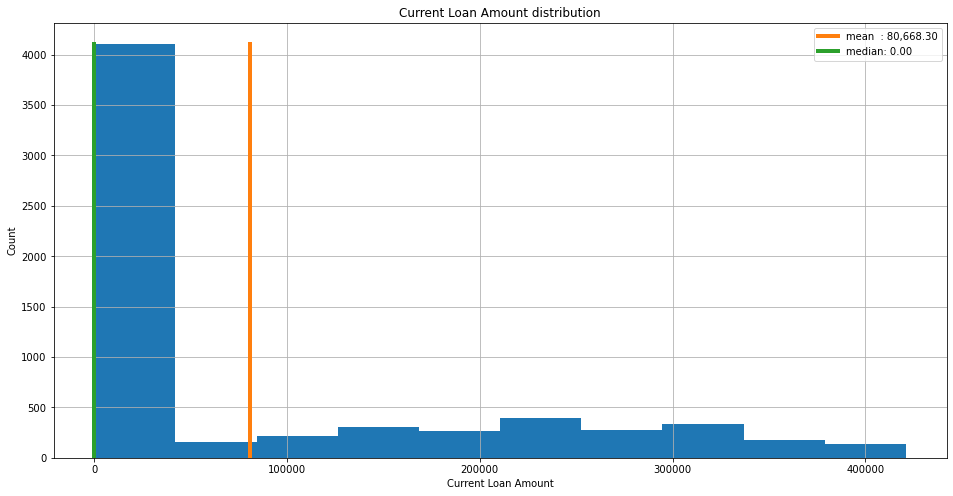

In [404]:
first_look(df_train['Current Loan Amount'], quan=0.85)

In [405]:
df_train.loc[df_train['Current Loan Amount'] > 1000000, 'Current Loan Amount'].count()


371

In [406]:
df_train.loc[df_train['Current Loan Amount'] > 1000000, 'Current Loan Amount']

6       99999999.0
46      99999999.0
100     99999999.0
104     99999999.0
108     99999999.0
           ...    
7330    99999999.0
7334    99999999.0
7376    99999999.0
7464    99999999.0
7475    99999999.0
Name: Current Loan Amount, Length: 371, dtype: float64

Гипотеза: Около 1000 значений 99999999 явно сбойных значений или -1?

In [407]:
df_train.loc[df_train['Current Loan Amount'] < 1000000, 'Current Loan Amount'].sort_values().tail(50)

3677    771232.0
3931    771694.0
3501    771958.0
6810    772310.0
1357    772618.0
3859    772706.0
6034    772860.0
5130    773784.0
5102    773784.0
2978    773850.0
3766    774554.0
2885    775632.0
3227    777480.0
2474    777546.0
6204    777854.0
942     778558.0
6898    778866.0
4766    779944.0
7018    779944.0
7357    780934.0
2690    781176.0
4981    781396.0
3210    781440.0
4152    781550.0
2622    781638.0
6813    781792.0
2007    781858.0
1083    782166.0
2084    782562.0
5969    782782.0
3576    782870.0
310     783244.0
997     783706.0
1215    783860.0
6815    784938.0
6764    785708.0
5415    785862.0
3165    786478.0
2785    786478.0
3988    787028.0
4261    787094.0
3640    787490.0
5038    787490.0
1416    787556.0
7478    787864.0
6708    788018.0
2420    788634.0
359     788634.0
4602    788788.0
4960    789030.0
Name: Current Loan Amount, dtype: float64

 
### Current Credit Balance - текущий кредитный баланс

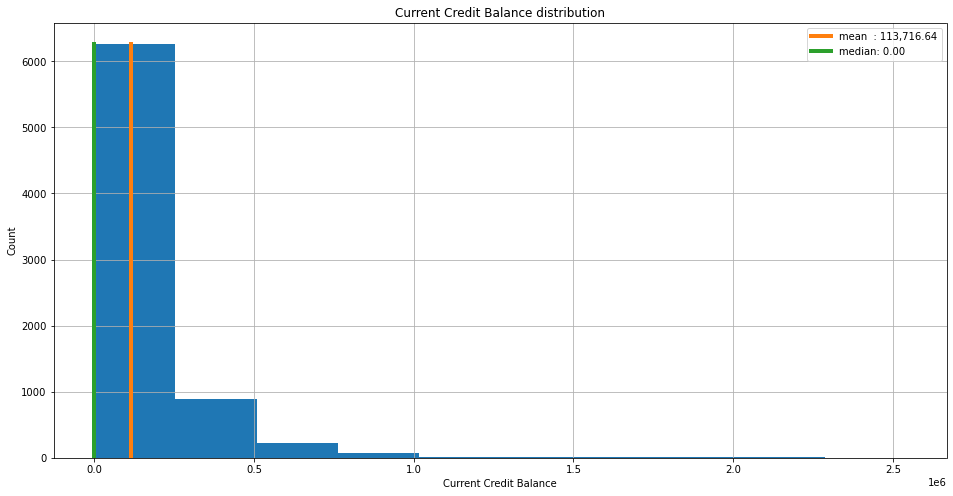

In [408]:
first_look(df_train['Current Credit Balance'])

In [409]:
df_train['Current Credit Balance'].describe()

count    7.500000e+03
mean     1.172872e+05
std      2.355779e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.677890e+05
max      4.367245e+06
Name: Current Credit Balance, dtype: float64

<AxesSubplot:xlabel='Current Credit Balance'>

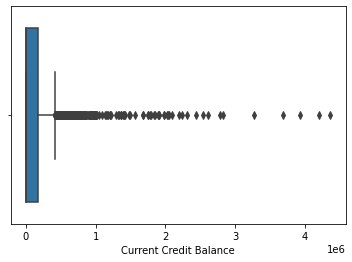

In [410]:
sns.boxplot(x=df_train['Current Credit Balance'], )

In [411]:
df_train['Current Credit Balance'].sort_values().tail(50)

4031    1129987.0
7459    1149614.0
3931    1161033.0
2064    1170837.0
2068    1201218.0
1334    1210680.0
5618    1221339.0
6813    1288504.0
7334    1327777.0
4796    1331178.0
7114    1359602.0
1573    1361483.0
7251    1369577.0
6240    1389052.0
6880    1402276.0
5045    1406190.0
2962    1421808.0
1105    1483026.0
1634    1488365.0
6505    1571243.0
7377    1673558.0
4255    1675876.0
1336    1745682.0
561     1754308.0
1365    1774220.0
6111    1799680.0
3399    1842449.0
2850    1857117.0
3352    1893597.0
3541    1904864.0
2763    1908550.0
5523    1975012.0
1879    1985462.0
2431    2024659.0
5276    2044875.0
3601    2059942.0
5818    2097353.0
5542    2194310.0
6265    2240594.0
2468    2315169.0
7026    2440246.0
1601    2540756.0
2482    2611835.0
4840    2784108.0
837     2833451.0
1931    3271629.0
3198    3683340.0
2618    3927471.0
7278    4209659.0
4602    4367245.0
Name: Current Credit Balance, dtype: float64

### Monthly Debt - ежемесячный долг

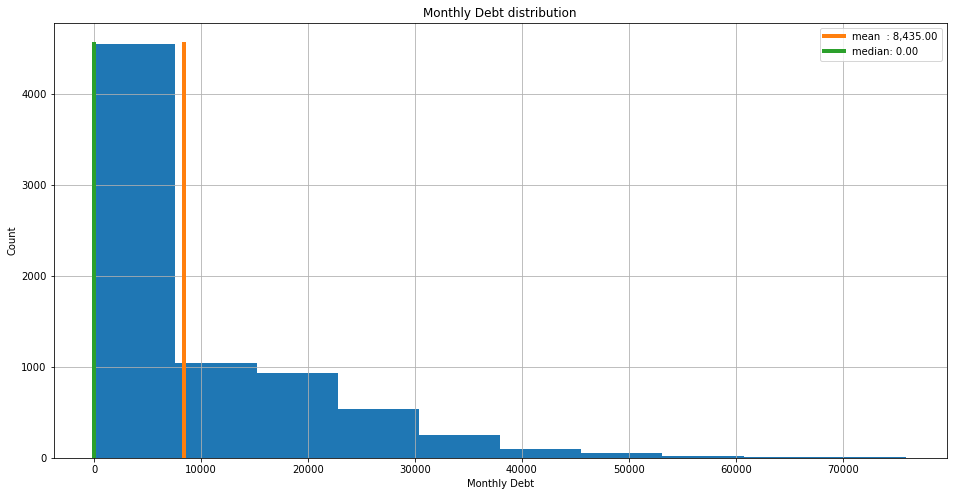

In [412]:
first_look(df_train['Monthly Debt'])

In [413]:
df_train['Monthly Debt'].describe()

count     7500.000000
mean      8518.898400
std      12198.411646
min          0.000000
25%          0.000000
50%          0.000000
75%      15507.500000
max      96177.000000
Name: Monthly Debt, dtype: float64

### Credit Score - баллы кредитного рейтинга

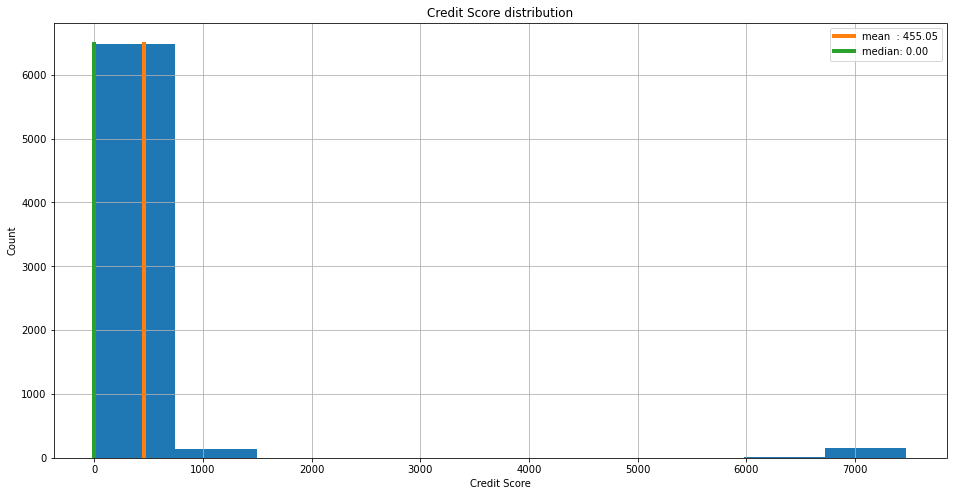

In [414]:
first_look(df_train['Credit Score'])

In [415]:
df_train['Credit Score'].describe()

count    6817.000000
mean      461.237935
std      1165.149358
min         0.000000
25%         0.000000
50%         0.000000
75%       720.000000
max      7510.000000
Name: Credit Score, dtype: float64

> Заполним медианой

## Категориальные переменные

### Home Ownership - домовладение

In [417]:
# dict_rus(df_train['Home Ownership'], ['Ипотека на дом','Аренда','Собственный дом','Ипотека'])


>Потенциал залога

> Гипотеза перекодировать в dummy, предметную характеристику дать невозможно

In [418]:
df_train['Home Ownership'].describe()

count     7500
unique       5
top          0
freq      4081
Name: Home Ownership, dtype: int64

In [419]:
pd.get_dummies(df_train['Home Ownership'],prefix='Home Ownership')

,Home Ownership_0,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
7495,1,0,0,0,0
7496,0,0,1,0,0
7497,1,0,0,0,0
7498,1,0,0,0,0


In [420]:
pd.get_dummies(df_train['Home Ownership'],prefix='Home Ownership').columns

Index(['Home Ownership_0', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent'],
      dtype='object')

### Years in current job - количество лет на текущем месте работы

In [421]:
df_train['Years in current job'].describe()

count     7324
unique      12
top          0
freq      4081
Name: Years in current job, dtype: int64

In [422]:
df_train['Years in current job'].value_counts()

0            4081
10+ years    1148
2 years       294
3 years       255
< 1 year      235
5 years       227
1 year        226
4 years       225
7 years       188
6 years       175
8 years       147
9 years       123
Name: Years in current job, dtype: int64

In [423]:
df_train.loc[df_train['Years in current job']== 0, 'Years in current job'].count()

4081

In [424]:
df_train['Years in current job'].isna().sum()

176

>Гипотеза кодировка строчной в вещественный

>Гипотеза nan в < 1 

In [425]:
df_train['Years in current job'].unique()


array([0, '10+ years', '1 year', '2 years', '6 years', nan, '< 1 year',
       '4 years', '8 years', '5 years', '7 years', '9 years', '3 years'],
      dtype=object)

In [426]:
l=['10+ years', '1 year', '2 years', '6 years', '< 1 year', '4 years', '8 years', '5 years', '7 years', '9 years', '3 years']
l.sort()
l

['1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year']

### Purpose - цель кредита

In [427]:
df_train['Purpose'].value_counts()

#print(df_train.Purpose.value_counts())

0                       4081
debt consolidation      2685
other                    303
home improvements        207
business loan             49
buy a car                 43
medical bills             40
take a trip               18
major purchase            18
buy house                 17
small business            13
wedding                    7
educational expenses       7
vacation                   6
moving                     5
renewable energy           1
Name: Purpose, dtype: int64

In [428]:
df_train['Purpose'].describe()

count     7500
unique      16
top          0
freq      4081
Name: Purpose, dtype: int64

>Гипотеза целый словарь - что делать не понятно

### Term - срок кредита

In [429]:
df_train['Term'].value_counts()

0             4081
Short Term    2526
Long Term      893
Name: Term, dtype: int64

In [430]:
df_train['Term'].describe()

count     7500
unique       3
top          0
freq      4081
Name: Term, dtype: int64

>Гипотеза перекодировать в бинарный.

In [431]:
df_train['Term'].unique()

array([0, 'Short Term', 'Long Term'], dtype=object)

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [432]:
df_train.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [433]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [434]:
df_train.isna().sum()

Home Ownership                    0
Annual Income                     0
Years in current job            176
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                     14
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                    683
Credit Default                    0
dtype: int64

**Решение по признакам**

In [536]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Annual Income
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        # Months since last delinquent
        X.loc[X['Months since last delinquent'].isna(),'Months since last delinquent']=0
        
        # Bankruptcies
        X.loc[X['Bankruptcies'].isna(),'Bankruptcies']=0
        
        # Credit Score
        X.loc[X['Credit Score'].isna(),'Credit Score']=self.medians['Credit Score']
        
        # Years in current job
        X.loc[X['Years in current job'].isna(),'Years in current job']="< 1 year"

        #X.fillna(self.medians, inplace=True)
        
        return X

In [537]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.years_to_dec = None        
        self.terms_to_dec = None
        
    def fit(self, X):
        X = X.copy()
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.terms_to_dec = { 'Short Term':0, 'Long Term':1}
        self.years_to_dec = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4 , '5 years':5, '6 years':6,
                      '7 years':7, '8 years':8, '9 years':9, '10+ years':10}
        X['Term encode'] = 0
        X['Years in current job encode'] = 0
        return X
        
    def transform(self, X):
        
        # Home Ownership
        X=pd.concat([X, pd.get_dummies(X['Home Ownership'], prefix='Home Ownership')], axis=1)
    
        # Years in current job
        X['Years in current job'] = X['Years in current job'].map(self.years_to_dec)
        
        # Term
        X['Term'] = X['Term'].map(self.terms_to_dec)
        
        return X


In [538]:
TARGET_NAME = 'Credit Default'

In [539]:
NUM_FEATURE_NAMES = [
 'Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount', # 99999999.0
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
# encode
    'Years in current job', 
    'Term'
]

CAT_FEATURE_NAMES = [
#     'Home Ownership', # в dummy
#    'Years in current job',  
    'Purpose' ]

NEW_FEATURE_NAMES = ['Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent']

# SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES+ CAT_FEATURE_NAMES
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [544]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=TARGET_NAME)
y = train_df[TARGET_NAME]

In [545]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [546]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5025, 16), (2475, 16), (2500, 16))

In [547]:
features_gen = FeatureGenerator()
features_gen.fit(X_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5025, 20), (2475, 20), (2500, 20))

In [548]:
X_train[SELECTED_FEATURE_NAMES]


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Years in current job,Term,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
3802,1008748.0,0.0,10.0,17.6,328064.0,0.0,2.0,0.0,99999999.0,186713.0,13198.0,729.0,2,0,0,1,0,0
6500,2237136.0,0.0,10.0,23.6,1639792.0,0.0,0.0,0.0,604428.0,543818.0,38031.0,749.0,10,0,0,0,0,1
7062,1479245.0,0.0,11.0,15.3,604824.0,0.0,0.0,0.0,428208.0,375554.0,10712.0,692.0,4,0,0,1,0,0
2926,852777.0,0.0,16.0,5.8,516142.0,0.0,0.0,0.0,99999999.0,172501.0,16132.0,720.0,5,0,0,0,0,1
2635,768360.0,0.0,6.0,11.0,315722.0,0.0,0.0,0.0,213532.0,179417.0,4604.0,718.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,1178712.5,0.0,14.0,18.7,252670.0,0.0,29.0,0.0,323796.0,94696.0,25005.0,731.0,8,1,0,1,0,0
772,1178712.5,0.0,8.0,16.9,694562.0,0.0,0.0,0.0,492118.0,448077.0,16048.0,731.0,10,1,0,1,0,0
5944,2365367.0,0.0,16.0,23.6,3007136.0,0.0,0.0,0.0,152152.0,1742642.0,47347.0,742.0,5,0,0,1,0,0
5327,855969.0,0.0,10.0,22.0,484990.0,0.0,0.0,0.0,495022.0,332158.0,12982.0,655.0,10,1,0,1,0,0


In [549]:
X_train = X_train[SELECTED_FEATURE_NAMES]
X_valid = X_valid[SELECTED_FEATURE_NAMES]
test_df = test_df[SELECTED_FEATURE_NAMES]

### Балансировка <a class="anchor" id="balance"></a> 

In [589]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    3611
0    3611
Name: Credit Default, dtype: int64

In [590]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 


In [599]:
class ModelFabric():
    def buildLogReg():
        return LogisticRegression(class_weight='balanced', C=1)
    def buildKnn():
        return KNeighborsClassifier(n_neighbors=8)
        

**Логистическая регрессия**

In [591]:
model = ModelFabric.buildLogReg()
# model.fit(X_train, y_train)
model.fit(X_train_balanced, y_train_balanced)
# evaluate_preds(model, X_train, X_valid, y_train, y_valid)
evaluate_preds(model, X_train_balanced, X_valid, y_train_balanced, y_valid)


TRAIN

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      3611
           1       0.64      0.74      0.69      3611

    accuracy                           0.67      7222
   macro avg       0.67      0.67      0.66      7222
weighted avg       0.67      0.67      0.66      7222

TEST

              precision    recall  f1-score   support

           0       0.82      0.55      0.66      1776
           1       0.38      0.69      0.49       699

    accuracy                           0.59      2475
   macro avg       0.60      0.62      0.57      2475
weighted avg       0.69      0.59      0.61      2475

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               979  797
1               217  482


> по уполчанию macro avg 0.59/0.59 но низкая оценка на 1 классе - 0.33

> class_weight='balanced' 0.6/0.59  классы сбалансированы

> общий вывод - **низкая оценка 0.60** на kaggle - 0.52922

> После балансировки 66/57 на kaggle - 0.52980

**k ближайших соседей**

In [600]:
model = ModelFabric.buildKnn()


model.fit(X_train_balanced, y_train_balanced)
evaluate_preds(model, X_train_balanced, X_valid, y_train_balanced, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      3611
           1       0.76      0.84      0.80      3611

    accuracy                           0.79      7222
   macro avg       0.79      0.79      0.79      7222
weighted avg       0.79      0.79      0.79      7222

TEST

              precision    recall  f1-score   support

           0       0.76      0.62      0.68      1776
           1       0.34      0.49      0.40       699

    accuracy                           0.59      2475
   macro avg       0.55      0.56      0.54      2475
weighted avg       0.64      0.59      0.60      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1108  668
1                359  340


>по умолчанию 70/54 - оценка увеличилась, **на kaggle - 0.23** дисбаланс?

> При балансировке классов 80/53 - переобучение вероятно из за синтетики балансировки на kaggle - 0.48180

> увеличить k до 8 для предотв перебучения - 80/54 на kaggle - 0.45522

**Support Vector Machine**

### Запись результатов <a class="anchor" id="save_result"></a> 


In [601]:
predictions = model.predict(test_df)
predictions

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [602]:
submit = pd.read_csv(SAMPLE_PATH)
# submit.head()
submit['Credit Default'] = predictions
# submit.head()

In [603]:
submit.to_csv('./rf_submit.csv', index=False)